In [1]:
import torch
import torch.nn.functional as F
from torch.nn import Linear
import pandas as pd
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split
from torch_geometric.nn import SAGEConv, global_mean_pool, GATConv
from utils import filling, kmeans_clustering, plot_clusters, get_feature_propagation
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

In [2]:
data = torch.load('Data/santiago_zero_ismt.pt')
data.comuna = data.x[:, 8]
data.ismt = data.x[:,-1]
data.lat = data.x[:,0]
data.lon = data.x[:,1]
data.x = data.x[:, 2:8]
print(data)
print(data.x)
print(data.lat)
print(data.comuna)
print(data.ismt)
print(data.edge_index)
print(data.edge_attributes)

data.ismt = data.ismt.float()

Data(x=[355936, 6], edge_index=[2, 673565], edge_attributes=[673565, 2], comuna=[355936], ismt=[355936], lat=[355936], lon=[355936])
tensor([[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 1.5074, -1.1100, -1.6402,  1.2143,  1.6439,  1.6780],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000]])
tensor([-33.4416, -33.4420, -33.4429,  ..., -33.4390, -33.4389, -33.4386])
tensor([39., 39., 39.,  ..., 42., 42., 42.])
tensor([0.8805, 0.8805, 0.8594,  ..., 0.8625, 0.8625, 0.8625])
tensor([[     0,      1,      2,  ..., 355934, 355935, 355935],
        [  4463,   4467,    488,  ..., 191461, 251187,   7949]])
tensor([[80.8500,  5.8000],
        [18.8300,  1.3000],
        [16.0600,  1.1000],
        ...,
        [33.0400,  4.1000],
        [ 2.5300,  0.2000],
    

In [3]:
data.x = get_feature_propagation(data)

Starting feature filling
tensor([[-1.8762,  0.0880,  1.8812, -0.7552, -2.0797, -1.2788],
        [ 0.2155, -0.1407, -0.2000,  0.7840,  0.9977,  0.7484],
        [ 0.0507, -1.1760, -0.3934,  1.3322,  0.4679,  0.7087],
        ...,
        [ 1.0445, -1.0450, -1.3092,  1.1516,  1.1633,  1.0873],
        [ 1.5074, -1.1100, -1.6402,  1.2143,  1.6439,  1.6780],
        [ 1.2992, -0.1245, -1.1497,  0.2336,  1.0391,  0.9675]])
Feature filling completed. It took: 2.17s


In [4]:
index_list = data.edge_index.flatten().unique().tolist()

# Porcentaje de índices para cada conjunto
train_percentage = 0.8
val_percentage = 0.1

# Dividir en conjuntos de entrenamiento y prueba
train_index, remaining_index = train_test_split(index_list, train_size=train_percentage, random_state=42)

# Dividir el resto en conjuntos de validación y prueba
val_index, test_index = train_test_split(remaining_index, train_size=val_percentage / (1 - train_percentage), random_state=42)

print("Training set length:", len(train_index))
print("Validation set length:", len(val_index))
print("Test set length:", len(test_index))

n_nodes, n_features = data.x.shape

train_mask = torch.zeros(n_nodes, dtype=torch.bool)
val_mask = torch.zeros(n_nodes, dtype=torch.bool)
test_mask = torch.zeros(n_nodes, dtype=torch.bool)

train_mask[train_index] = True
val_mask[val_index] = True
test_mask[test_index] = True
data['train_mask'] = train_mask
data['val_mask'] = val_mask
data['test_mask'] = test_mask

Training set length: 284748
Validation set length: 35594
Test set length: 35594


In [14]:
class GATRegression(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers):
        super(GATRegression, self).__init__()
        self.conv1 = GATConv(in_channels, hidden_channels)
        self.convs = torch.nn.ModuleList()
        for _ in range(num_layers - 1):
            self.convs.append(GATConv(hidden_channels, hidden_channels))
        self.conv2 = GATConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        for conv in self.convs:
            x = F.relu(conv(x, edge_index))
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x
    
    def reset_parameters(self):
        self.conv1.reset_parameters()
        for conv in self.convs:
            conv.reset_parameters()
        self.conv2.reset_parameters()

In [58]:
in_features = data.x.shape[1]
hidden_features = 64
out_features = 1
num_layers = 2
epochs = 200
lr = 0.01

model = GraphSageRegression(in_features, hidden_features, out_features, num_layers)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

def train_model(model, data, mask):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)[mask]
    loss = criterion(out, data.ismt[mask].view(-1, 1))
    loss.backward()
    optimizer.step()
    return loss.item()

def evaluate_model(model, data, mask):
    model.eval()
    with torch.no_grad():
        pred = model(data.x, data.edge_index)[mask]
        mse = criterion(pred, data.ismt[mask].view(-1, 1))
        r2 = r2_score(data.ismt[mask].view(-1, 1), pred)
        mae = mean_absolute_error(pred, data.ismt[mask].view(-1, 1))
    return mse.item(), mae, r2

train_losses = []
val_losses = []
train_maes = []
val_maes = []

for epoch in range(epochs):
    train_loss = train_model(model, data, data.train_mask)
    val_mse, val_mae, r2 = evaluate_model(model, data, data.val_mask)

    train_losses.append(train_loss)
    val_losses.append(val_mse)
    val_maes.append(val_mae)
    
    print(f'Epoch: {epoch+1:03d}, Train Loss: {train_loss:.4f}, Val MSE: {val_mse:.4f}, Val R2: {r2:.4f}')

test_mse, test_mae, test_r2 = evaluate_model(model, data, data.test_mask)
print(f'Test MSE: {test_mse:.4f}, Test MAE: {test_mae:.4f}, Test R2: {test_r2:.4f}')

Epoch: 001, Train Loss: 0.8524, Val MSE: 0.1161, Val R2: -2.0855
Epoch: 002, Train Loss: 0.1687, Val MSE: 0.2338, Val R2: -5.2136
Epoch: 003, Train Loss: 0.3161, Val MSE: 0.1028, Val R2: -1.7331
Epoch: 004, Train Loss: 0.1649, Val MSE: 0.0781, Val R2: -1.0745
Epoch: 005, Train Loss: 0.1206, Val MSE: 0.1000, Val R2: -1.6589
Epoch: 006, Train Loss: 0.1306, Val MSE: 0.1182, Val R2: -2.1402
Epoch: 007, Train Loss: 0.1430, Val MSE: 0.1194, Val R2: -2.1724
Epoch: 008, Train Loss: 0.1428, Val MSE: 0.1049, Val R2: -1.7892
Epoch: 009, Train Loss: 0.1292, Val MSE: 0.0819, Val R2: -1.1760
Epoch: 010, Train Loss: 0.1099, Val MSE: 0.0593, Val R2: -0.5759
Epoch: 011, Train Loss: 0.0926, Val MSE: 0.0457, Val R2: -0.2135
Epoch: 012, Train Loss: 0.0860, Val MSE: 0.0439, Val R2: -0.1660
Epoch: 013, Train Loss: 0.0905, Val MSE: 0.0477, Val R2: -0.2665
Epoch: 014, Train Loss: 0.0979, Val MSE: 0.0477, Val R2: -0.2686
Epoch: 015, Train Loss: 0.0982, Val MSE: 0.0425, Val R2: -0.1298
Epoch: 016, Train Loss: 0

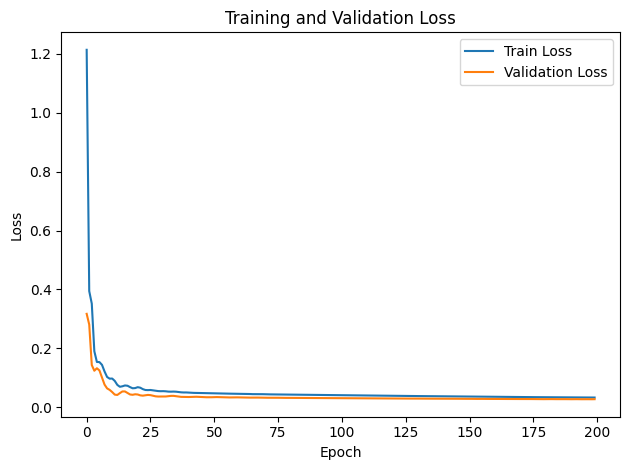

In [52]:

plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.tight_layout()
plt.show()
